# Learner
The learner framework will enable rapid experimentation and provide tools for introspection, multi-process CUDA acceleration, data augmentation, and flexible architecture testing.

In [1]:
#| default_exp learnerFULL

<span style='color:Blue'> 
NB: JH made changes to the code AFTER the lesson where this was presented.
To find those changes go to the course repo, add /compare in GitHub, and compare across different things.
One of the examples is to compare across different times, e.g., the master Branch now versus one day ago.
To change that to vs. 7 days ago, change in the URL to 7, i.e., to see the commits changes from last week. 
</span>

In [2]:
import logging
logging.disable(logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

In [3]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from warnings import warn

from torch import tensor,nn,optim
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *

from fastprogress import progress_bar,master_bar
from fastcore.test import test_close

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

### Preliminaries: 
From previous notebooks, using HuggingFace [Dataset](https://huggingface.co/docs/datasets/index).
The `load_dataset_builder()` function loads a dataset builder to inspect a dataset’s attributes without committing to downloading it.

In [5]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
x,y = ds_builder.info.features
x, y

('image', 'label')

In [6]:
dsd = load_dataset(name)

We define an `@inplace` transform `transformi(b)` which given a batch `b` 
converts each image `b[x]` (PIL Image or numpy.ndarray) into a tensor with Torchvision's [to_tensor](https://pytorch.org/vision/stable/generated/torchvision.transforms.functional.to_tensor.html).
<br>
`tds` is the transformed dataset dictionary, via Huggingface [Datasets](https://huggingface.co/docs/datasets/index) [with_transform()](https://huggingface.co/docs/datasets/v2.12.0/en/package_reference/main_classes#datasets.Dataset.with_transform).

In [7]:
@inplace
def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

tds = dsd.with_transform(transformi)

We create `dls`, an instance of the *miniai* `Dataloaders` with parallel processing. `dt` is the training dataloader.

In [8]:
bs = 1024
dls = DataLoaders.from_dd(dd=tds, batch_size=bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]   # xb has bs images, yb has bs labels

(torch.Size([1024, 784]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

### Basic Learner

<mark> A learner is something that is going to train or learn a particular `model`,
using a particular set of:  data loaders `dls`, loss function `loss_func`, learning rate `lr`, optimization function `opt_func`. </mark> <br>
`BasicLearner` is a simple learner that fits on one screen and replaces our `fit` function.
Lets look at some of its methods:
```Python
 def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()
```
The `__init__` calls `fc.store_attr()` to avoid (the boilerplate of) storing each of the input items separately.
```Python
   def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        #self.n_epochs = n_epochs  #What for?
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)
```            
The `fit()` method has `.accs` for tracking accuracy (for classification where we can use accuracy), `.losses`, and `.ns`. 
We put the `model` on the `def_device`, create the optimizer `opt`, (WHY? store how many `n_epochs` we're going through).
For each `epoch` we call `one_epoch()`, first to train (`True`) and then for validation evaluation (`False`).
```Python
def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, self.model.training, sum(self.losses).item()/n, sum(self.accs).item()/n)
```
In `one_epoch` we set `model.training` to training/validation mode, 
and set `dl` to the `train` or `valid` dataset accordingly.  
Using `enumerate(dl)` we go through each `batch` in the `dl` dataloader and call `one_batch()`.
```python
def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()
```
`one_batch()` saves the `xb` and `yb` parts of the batch, 
calls the `.model` saving the results in `.preds`, 
calls the loss function `loss_func` with the `.preds` and targets `yb`.
If it is training it does the backward pass (`loss.backward(); opt.step(); opt.zero_grad()`).
Then it `calc_stats()` to calculate the statistics (`accs, losses`) which are printed at the end of `one_epoch`.

In [9]:
class BasicLearner:
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD): fc.store_attr()

    def one_batch(self):
        self.xb,self.yb = to_device(self.batch)
        self.preds = self.model(self.xb)
        self.loss = self.loss_func(self.preds, self.yb)
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        acc = (self.preds.argmax(dim=1)==self.yb).float().sum()
        self.accs.append(acc)
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)

    def one_epoch(self, train):
        self.model.training = train
        dl = self.dls.train if train else self.dls.valid
        for self.num,self.batch in enumerate(dl): self.one_batch()
        n = sum(self.ns)
        print(self.epoch, "\t", self.model.training, "\t", f"{sum(self.losses).item()/n:.4f}", f"{sum(self.accs).item()/n:.4f}")
         
    def fit(self, n_epochs):
        self.accs,self.losses,self.ns = [],[],[]
        self.model.to(def_device)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        #self.n_epochs = n_epochs   #Removed by GSG as useless
        print("epoch training \t loss\taccuracy")
        for self.epoch in range(n_epochs):
            self.one_epoch(True)
            with torch.no_grad(): self.one_epoch(False)

`BasicLearner` is a simple starting point but lacks flexibility, limiting its use to multi-class classification tasks that rely on accuracy. 
It can't handle tasks like autoencoders that require custom prediction and calculation logic.

Lets define a simple `model` (Linear, ReLU, Linear) to test `BasicLearner`, and try it with the (MNIST) `dls`.

In [10]:
m,nh = 28*28,50
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

learn = BasicLearner(model, dls, loss_func=F.cross_entropy, lr=0.2)
learn.fit(2)

epoch training 	 loss	accuracy
0 	 True 	 1.1753 0.5988
0 	 False 	 1.1203 0.6136
1 	 True 	 0.9328 0.6742
1 	 False 	 0.9116 0.6811


Above is epoch number, training, loss, accuracy

## Callbacks

Default exceptions to be ignored.

In [11]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

Note that in `class Callback(): order = 0`
so all callbacks have the default order of zero unless we ask otherwise.

In [12]:
#|export
class Callback(): order = 0

`run_cbs` will run all the `cb` callbacks in `cbs` in order with [`sorted()`](https://docs.python.org/3/library/functions.html#sorted).
It uses [getattr()](https://docs.python.org/3/library/functions.html#getattr) to retrieve the `method` name in the `cb`.
(`getattr`: Get a named attribute from an object; `getattr(x, 'y')` is equivalent to `x.y`).
If the method exists, it calls it.

In [13]:
#|export
def run_cbs(cbs: list, method_nm: str, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)
        #else: print(f"Ignoring callback {method_nm}.")

### Understanding Callbacks - A Simple Callback CompletionCB
Let's run a simple callback `CompletionCB` (inherits from the class `Callback`)
Before we start fitting a new model it sets its `count=0`, and after each batch it increments `count`.
`after_fit()` will print out `count`, i.e., how many batches we've done.

In [14]:
class CompletionCB(Callback):
    def before_fit(self, learn): self.count = 0
    def before_batch(self, learn): pass
    def before_epoch(self, learn): pass
    def after_epoch(self, learn): pass
    def after_batch(self, learn): self.count += 1
    def after_fit(self, learn): print(f'Completed {self.count} batches')

(Before we even train a model) lets run (manually) `before_fit`,
`after_batch`, and `after_fit` using `run_cbs`, to make sure they work as we want.
We set the list of `cbs` to have a single member, `CompletionCB()`.

In [15]:
cbs = [CompletionCB()]
run_cbs(cbs=cbs, method_nm='before_fit')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'nonexistent')
run_cbs(cbs, 'before_batch')
run_cbs(cbs, 'after_batch')
run_cbs(cbs, 'after_fit')

Completed 2 batches


As expected, it printed "Completed n batches". 
`run_cbs` went through each `cb` (there's only one, `CompletionCB`) in the `cbs` list,
used `getattr` to find an attribute with the corresponding name for its `method`, (e.g., `before_fit`), and if it found it then called it. 
Notice how it ignored `nonexistent`.

<mark> NB: **Don't just run code *willy-nilly* but understand it by experimenting with it. Don't just use what is already created.** </mark> <br>
Lets do it all manually: create a callback `cb`. <br>
Q: What happens if we call `getattr` and pass in the `cb` callback?

In [16]:
cb = CompletionCB()

getattr(cb, 'after_batch', None)

<bound method CompletionCB.after_batch of <__main__.CompletionCB object at 0x14d354a10>>

A: `getattr()` returned a method. 
What happens to that method it gets called? let's try calling it.

In [17]:
getattr(cb, 'before_fit', None)(learn)

when we call the `before_fit` it doesn't do anything interesting.
But if we call `after_batch` and then call `after_fit` it does.

In [18]:
getattr(cb, 'after_batch', None)(learn)
getattr(cb, 'after_batch', None)(learn)

getattr(cb, 'after_fit', None)(learn)

Completed 2 batches


## Basic Callbacks Learner

The BasicLearner wasn't flexible, it hard coded that:
- we can only calculate accuracy and average loss
- we're putting things on a default device
- a single learning rate 

A basic callbacks learner `BasicCBLearner` is an intermediate step. 
Similar to the `BasicLearner`: it has `fit()`, `one_epoch()`, `one_batch`, etc. <mark> And a few more things..</mark>
For example, in `fit()`, after creating the optimizer, `self.opt = self.opt_func(self.model.parameters(), self.lr)`
`self.opt_func` defaults to `SGD`, as `opt_func=optim.SGD`.
We instantiate `opt`, an SGD object passing in the model's parameters, and the learning rate `lr`.
Before (after) each `one_epoch`, `fit` calls `callback('before_fit')` (`callback('after_fit')`).
`callback()` calls `run_cbs`, passes in `cbs` (the list of our input callbacks) and the method name `method_nm`.
`run_cbs` sorts the callbacks in their order attribute and invokes the methods.
Similar pattern inside `one_epoch` for every `one_batch`.

Below `BasicCBLearner` was simplified....

In [19]:
class BasicCBLearner():
    def __init__(self, model, dls, loss_func, lr, cbs, opt_func=optim.SGD): fc.store_attr()
     
    def one_batch(self):
        self.preds = self.model(self.batch[0])
        self.loss = self.loss_func(self.preds, self.batch[1])
        if self.model.training:
            self.loss.backward()
            self.opt.step()
            self.opt.zero_grad()

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        try:
            self.callback('before_epoch')
            for self.iter,self.batch in enumerate(self.dl):
                try:
                    self.callback('before_batch')
                    self.one_batch()
                    self.callback('after_batch')
                except CancelBatchException: pass
            self.callback('after_epoch')
        except CancelEpochException: pass
    
    def fit(self, n_epochs):
        #self.n_epochs = n_epochs
        #self.epochs = range(n_epochs)
        self.opt = self.opt_func(self.model.parameters(), self.lr)
        try:
            self.callback('before_fit')
            for self.epoch in range(n_epochs):
                self.one_epoch(True)
                self.one_epoch(False)
            self.callback('after_fit')
        except CancelFitException: pass

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)

Notice that there's a `try:` immediately before every `before_` method and a `except` immediately after every `after_` method.
Each one has a different exception to look for: 
`CancelFitException, CancelEpochException` (?, and `CancelBatchException`).
These exceptions get ignored, so that any of the callbacks could raise any one of these 3
exceptions to say "I don't want to do this batch please".

### Experimenting with exceptions
The `get_model()` function below creates a `nn.Sequential` model (Linear, ReLU, Linear).
We instantiate the `model` and the `learn` and call `fit()`. 
Since the only callback is `completionCB`, it just reports the number of batches as expected.

In [20]:
m,nh = 28*28,50
def get_model(): return nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

model = get_model()
learn = BasicCBLearner(model, dls, F.cross_entropy, lr=0.2, cbs=[CompletionCB()])
learn.fit(1)

Completed 64 batches


This trained `model` didn't print any metrics because it does not have any metric callbacks.

`SingleBatchCB(Callback)` after a single batch raises a `cancelEpochException`.
(Could be useful to just run one batch to make sure a model works).

In [21]:
class SingleBatchCB(Callback):
    def after_batch(self, learn): raise CancelEpochException()

We add `SingleBatchCB` to `cbs`, instantiate a `learn` and call `learn.fit` to try it.

In [22]:
learn = BasicCBLearner(get_model(), dls, loss_func=F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

Completed 0 batches


It ran, but nothing happened because `after_batch` raised `CancelEpochException()` which canceled the Epoch. 
We can make `SingleBatchCB` run second by setting its `order` higher, e.g., 1 (default order is 0), and `cbs_run` sorts by `order` attribute.

In [23]:
#| export
class SingleBatchCB(Callback):
    order = 1
    def after_batch(self, learn): raise CancelEpochException()

In [24]:
learn = BasicCBLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[SingleBatchCB(), CompletionCB()])
learn.fit(1)

Completed 2 batches


**Callbacks** are simply callables that get passed into a function or class, which then invokes them at specific times. 
They can have multiple methods, allowing for flexible and customized behavior.

## Metrics

A `Metric` class for tracking and calculating metrics,  e.g., accuracy and loss. 
This class provides a basic structure for implementing custom metrics, allowing for tracking, accumulation, and calculation of weighted averages.
-  `__init__` calls the `reset()` method, which sets up two empty lists: `vals` to store metric values and `ns` to store sample sizes.
-  `add()` method calculates a metric value using the `calc()` method, appends it in `vals`, and appends the sample size `n` to `ns`.
-  `value @property` calculates a *weighted average* of the metric values, where the weights are the sample sizes.
-  `calc()` method is a placeholder that simply returns the input `inps`. `calc()` would be overridden in subclasses to calculate specific metrics.

In [25]:
class Metric:
    def __init__(self): self.reset()
    def reset(self): self.vals,self.ns = [],[]
    def add(self, inp, targ=None, n=1):
        self.last = self.calc(inp, targ)
        self.vals.append(self.last)
        self.ns.append(n)
    @property
    def value(self):
        ns = tensor(self.ns)
        return (tensor(self.vals)*ns).sum()/ns.sum()
    def calc(self, inps, targs): return inps

### Example: Accuracy metric
Lets define an `Accuracy(Metric)` by defining (overidding) `calc()` as
the `mean()` of how often the input `inps` equals the targets `targs`.

In [26]:
class Accuracy(Metric):
    def calc(self, inps, targs): return (inps==targs).float().mean()

Below `acc` is an `Accuracy` metric object. We `add` a few batches of inputs and targets,
and get the `acc.value`, i.e., the accuracy.

In [27]:
acc = Accuracy()
acc.add(tensor([0, 1, 2, 0, 1, 2]), tensor([0, 1, 1, 2, 1, 0]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([0, 1, 1, 2, 1]))
acc.add(tensor([1, 1, 2, 0, 1]), tensor([1, 1, 2, 0, 1]))
acc.value.item()

0.6333333253860474

NB: `acc.value` is a `@property`, thus we didn't have to put `()` after it to get the calculation to happen.

Another way: `wa` is a `Metric` which simply gets the weighted average.
`add` 0.6 (loss with batch size of 32); `add` 0.9 (loss w/batch size of 2);
That gives us a weighted average loss of 0.62 which is equal to the (manual) weighted average calculation.

In [28]:
wa = Metric()
wa.add(0.6, n=32)
wa.add(0.9, n=2)
wa.value, round((0.6*32+0.9*2)/(32+2), 2)

(tensor(0.62), 0.62)

We can define a `Metric` class to create any metric by overwriting `calc`.
Or we could create things from scratch, as long as they have an `add()` and a `value`.

## Some callbacks to print out, etc

Lets define a `deviceCB(Callback)`, to use a device (eg GPU, MPS) without the earlier complications,
i.e., to allow multiple processes in the dataloader and also use the device. 
<br>
`before_fit()` puts the model onto the default device, and `before_batch()` put the batch onto the `device`.
<br>
NB: In the learner everything is put inside self which means it's all modifiable.

In [29]:
#|export
class DeviceCB(Callback):
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)

We check that the `deviceCB` callback works by using the earlier learner, `BasicCBLearner` replacing `SingleBatchCB()` by  `deviceCB()`.

In [30]:
learn = BasicCBLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), CompletionCB()])
learn.fit(1)

Completed 64 batches


#### Torcheval - DEPRECATED - had problems. Avoid it.
We could use [Torcheval](https://pytorch.org/torcheval/stable/), 
a PyTorch project that offers a range of pre-built metrics with `.update` and `.compute` methods. 
It's currently in alpha and doesn't have a stable release, which might impact its compatibility and functionality.
It had issues and it seems no longer being maintained. 

#### Torchmetrics
Instead of implementing every metric from scratch, we can use [Torchmetrics](https://lightning.ai/docs/torchmetrics/stable/), 
a PyTorch project that offers a range of pre-built metrics. 
Let's use [MulticlassAccuracy](https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html#torchmetrics.classification.MulticlassAccuracy) 
to calculate the frequency of inputs matching targets.

In [31]:
!pip install -q torchmetrics

In [32]:
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.aggregation import MeanMetric as Mean

We create a `MulticlassAccuracy` `metric` and we pass in a minibatch of inputs and targets.
Half of them match so the accuracy is .5

In [33]:
metric = MulticlassAccuracy(num_classes=4)
metric(tensor([0, 1, 2, 3, 0, 1]), tensor([0, 1, 2, 0, 3, 2]))

tensor(0.50)

The metrics API provides `update()`, `compute()`, `reset()` functions.
We call `reset` at the start of each epoch.
Recommendations for memory management:
-  When done with a metric, call reset() method. The python garbage collector can struggle to totally clean the metric states if this is not done. This can lead to a memory leak if multiple instances of the same metric for different purposes are created in the same script.
-    Always try to reuse the same instance of a metric instead of initializing a new one. Calling the reset method returns the metric to its initial state, and can therefore be used to reuse the same instance. However, we still highly recommend to use different instances from training, validation and testing.
-    If only the results on a batch level are needed e.g., no aggregation or alternatively if you have a small dataset that fits into iteration of evaluation, we can recommend using the functional API instead as it does not keep an internal state and memory is therefore freed after each call.

In [34]:
metric.reset()
metric.compute()

tensor(0.)

Below `to_cpu(x)` function calls `detach()` to remove 
all the computation history used to calculate a gradient, and also puts the tensor on the CPU.
It'll do the same for dictionaries, lists and tuples of tensors.
`to_cpu(x)` recursively moves PyTorch tensors and nested data structures (dictionaries, lists, and tuples) from their current device (likely a GPU) to the CPU. Here's a breakdown:

    Handling nested data structures:
        If x is a dictionary (Mapping), it recursively applies to_cpu to each value in the dictionary.
        If x is a list, it applies to_cpu to each element in the list.
        If x is a tuple, it converts the tuple to a list, applies to_cpu to each element, and then converts it back to a tuple.
    Moving tensors to CPU:
        If x is a PyTorch tensor, it detaches the tensor from the computation graph (using detach()) and moves it to the CPU (using cpu()).
        If the tensor's data type is torch.float16 (half precision), it converts the tensor to float32 precision using float().

The purpose of this function is likely to:
    Free up GPU memory by moving tensors to the CPU.
    Convert tensors to a consistent data type (float32) for certain operations or further processing.
    Prepare tensors for use in environments where GPU access is not available or necessary.

This function assumes that `x` is either a PyTorch tensor or a nested structure containing PyTorch tensors. If x is neither a tensor nor a supported nested structure, the function will raise a `TypeError`.

In [35]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    if isinstance(x, torch.Tensor):
        res = x.detach().cpu()
        return res.float() if res.dtype == torch.float16 else res
        
    raise TypeError(f"to_cpu function: Unsupported type: {type(x)}. Expected PyTorch tensor or nested structure containing PyTorch tensors.")


### `MetricsCB(Callback)`

<!-- This text will not be visible in the rendered Markdown
([Mean](https://pytorch.org/torcheval/stable/generated/torcheval.metrics.Mean.html#torcheval.metrics.Mean) 
 -->

When initializing MetricsCB(Callback), we pass in metric objects, which can be provided as positional arguments or named arguments. 
If positional arguments are used, they're automatically assigned names based on their class type (`type(o).__name__`). 
These metrics are stored in self.metrics. 
To allow for modifications without affecting the original, a copy of the metrics is created in all_metrics.
And add the `loss` as the weighted average of the losses using [MeanMetric](https://lightning.ai/docs/torchmetrics/stable/aggregation/mean.html)
<br>
In `before_fit`, we register the metrics callback with the Learner `learn`. 
In `before_epoch`, we reset all metrics. 
After each epoch, we create a dictionary of metrics to log and call `_log` to print them. 
After each batch, we move inputs and targets to the CPU, update each metric with the batch data, and also update the loss metric with the actual loss and minibatch size.

In [36]:
#|export
class MetricsCB(Callback):
    def __init__(self, *ms, **metrics):
#       import pdb; pdb.set_trace()
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean() # Mean() is alias to MeanMetric()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.4f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = to_cpu(learn.batch)
        for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=len(x))

`metrics` below is a `MetricsCB` object that calculates and print out `accuracy`.
We pass `metrics` as a `cbs` to the `BasicCBLearner`.
During `learn.fit()` it's going to print the `accuracy`, `loss`, `epoch` number, and whether it's training or evaluating.

In [37]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy(num_classes=len(ds_builder.info.features["label"].names)))
learn = BasicCBLearner(model, dls, F.cross_entropy, lr=0.2, cbs=[DeviceCB(), metrics])
learn.fit(1)

{'accuracy': '0.6053', 'loss': '1.1873', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.7008', 'loss': '0.8133', 'epoch': 0, 'train': 'eval'}


## Flexible Learner with Callbacks 

Class `_CbCtxInner` implements a context manager.
It is passed the calling class `outer`, e.g., the Learner's `self`, and `nm` the name of the method.
In `__enter__`  it calls `outer.callback(f'before_{self.nm}')`,  where e.g., `{nm}` is `'fit'`. 
In `__exit__` it needs to grab the `CancelFitException` (by using the key `f'Cancel{self.nm.title()}Exception'` in the `globals` dictionary.
In Python, global variables are stored in a dictionary accessible via the [globals()](https://docs.python.org/3/library/functions.html#globals) function, which returns the current global symbol table.
We look up in that dictionary the variable `Cancel{...}Exception` and store it in `chk_exc`.
If `exc_type` is not an exception we call `self.outer.callback(f'after_{self.nm}')`, and if it is we ignore it.
`finally:` we call the `cleanup_{self.nm}` callback. 

In [38]:
#|export
class _CbCtxInner:
    def __init__(self, outer, nm): self.outer,self.nm = outer,nm
    def __enter__(self): self.outer.callback(f'before_{self.nm}')
    def __exit__ (self, exc_type, exc_val, traceback):
        chk_exc = globals()[f'Cancel{self.nm.title()}Exception']
        try:
            if not exc_type: self.outer.callback(f'after_{self.nm}')
            return exc_type==chk_exc
        except chk_exc: pass
        finally: self.outer.callback(f'cleanup_{self.nm}')

### Class Learner()
In `one_epoch()` (below) we grab the training or validation set based on the argument `train`.
We then use the `epoch` context manager, `cb_ctx('epoch')`.
Loop through each `batch` in the `dl` dataloader. 
Then for each batch in `dl` using the `batch` context manager `cb_ctx('batch')`:
<br>
**interesting**
we call self `.predict(), .get_loss()` and, if we're training, `.backward(), .step()`, and `.zero_grad()`.
<br>
Previously we called `.model()`, `.loss()`, etc., but now we call instead `.predict()`, `.get_loss()`, etc.
*But these are not defined here, so how does it work?*
We do it for flexibility, so we can change them (e.g., `predict`, `get_loss`, etc.) for different situations.
<br>
What happens if we call `self.predict()` and it doesn't exist?
It doesn't necessarily cause an error as it calls `__getattr__(self.name)`.
The [`__getattr__`](https://python-reference.readthedocs.io/en/latest/docs/dunderattr/getattr.html) 
is a special method called when an attribute lookup has **not found** the attribute in the usual places 
(i.e. it is not an instance attribute nor is it found in the class tree for self).
In the definition of `__getattr__()` below, if `name` is in the special list (`['predict','get_loss','backward','step','zero_grad']`) 
it `return partial(self.callback, name)`. 
Else, `name` is not on the special list, then it `raise AttributeError(name)`.
To make this work we define below a callback **(`TrainCB`) which implements the 5 special names in the list**, and pass it along as a `cbs`.

In [39]:
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()
    
    def cb_ctx(self, nm): return _CbCtxInner(self, nm)

    def one_epoch(self, train):
        self.model.train(train)
        self.dl = self.dls.train if train else self.dls.valid
        with self.cb_ctx('epoch'):
            for self.iter,self.batch in enumerate(self.dl):
                with self.cb_ctx('batch'):
                    self.predict()
                    self.get_loss()
                    if self.training:
                        self.backward()
                        self.callback('after_backward')
                        self.step()
                        self.callback('after_step')
                        self.zero_grad()
    
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            #self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            with self.cb_ctx('fit'):
                for self.epoch in self.epochs:   # self.epochs:
                    if train: self.one_epoch(True)
                    if valid: torch.no_grad()(self.one_epoch)(False)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

Notice Python's flexibility. If any of the 5 in the list don't exist it will use `__getattr__` 
to find them  in the callbacks.
We could have multiple callbacks that define these things and then chain them together.

<div style="border: 2px solid blue; background-color: lightblue; padding: 10px;">
**HW Q**: Why we didn't have to say `with torch.no_grad` but instead call `torch.no_grad()`
Great if you understand why that works/what it does, will help understanding of decorators.
<br>
A: In PyTorch, `torch.no_grad()` is a context manager that disables the computation and storage of gradients during operation execution.
This is beneficial for inference, as we will not call `Tensor.backward()`, to reduce memory consumption.
<br>
In above `torch.no_grad()(self.one_epoch)` returns a *version* of `self.one_epoch` that will run with gradient computation disabled.
`(False)` calls the returned function, passing `False` as an argument.
<br>
Thus, the entire expression is equivalent to running the `one_epoch` method with `False` as an argument, but without tracking gradient computations. 
This might be used, for instance, if `one_epoch` is a method that performs a single training epoch and takes a boolean indicating whether or not to use backpropagation, and in this case, we're saying not to.
</div>

In `TrainCB` they're almost the same as in `BasicCBLearner`, but must have `learn` in front of each (`preds`, `loss`, etc.),
because this is a callback, it's not the learner.
<br>
NB: JH added `n_inp` to `TrainCB` so we can train models with more than one input or output.

In [40]:
class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

Lets now test the Flexible learner...

In [41]:
model = get_model()
metrics = MetricsCB(accuracy=MulticlassAccuracy(num_classes=len(ds_builder.info.features["label"].names)))
cbs = [TrainCB(), DeviceCB(), metrics]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(1)

{'accuracy': '0.6016', 'loss': '1.1488', 'epoch': 0, 'train': 'train'}
{'accuracy': '0.6857', 'loss': '0.9006', 'epoch': 0, 'train': 'eval'}


## Progress bar

In [42]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
     

Let's create a `ProgressCB(Callback)` to show our current loss using [Fastprogress](https://github.com/fastai/fastprogress), 
a *progress bar* for Jupyter Notebook (and console).
With FastProgress we can modify how metrics are displayed, e.g., replace the bar with an HTML table.
<br>
In `before_fit` we set `learn.epochs`, so instead of a normal range it is a progress bar around a range `master_bar(learn.epochs)`.
<br>
`MetricsCB` had a `_log` method, (instead of just `print`), so we can now replace how metrics are displayed.
If the learner has a `metrics` attribute, `hasattr(self.learn, 'metrics')` we replace the `metrics._log` method 
to write to the progress bar.
<br>
`Before_epoch` we do a similar thing: the `learn.dl` iterator we change to have a `progress_bar` wrapped around it.
And then `after_batch` we set `learn.dl.comment = f'{learn.loss:.3f}'`, so it will show `loss` on the progress bar.
And if we've asked to plot `if self.plot` then we will append the losses to a list of losses 
and we `update_graph` with the losses and the batch numbers.
`after_epoch` if not training, we show the validation losses in the plot.

In [43]:
#|export
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dls.train)), self.val_losses]])
     

NB: Added validation loss plotting after the lesson. Let's get the model and train and in real time see updates to the graph.

In [44]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy(num_classes=len(ds_builder.info.features["label"].names)))
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.1, cbs=cbs)

accuracy,loss,epoch,train
0.5862,1.3834,0,train
0.6740,0.9204,0,eval
0.7096,0.8121,1,train
0.7288,0.7511,1,eval


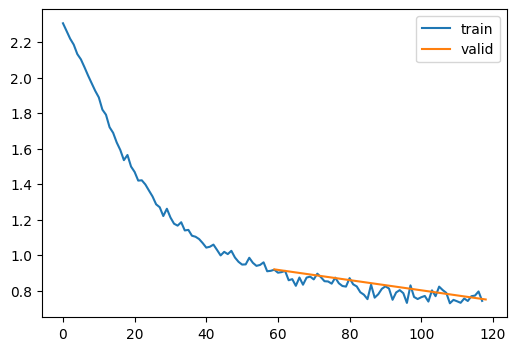

In [45]:
learn.fit(2)

We now have a working flexible learner, which we can understand, 
and a framework which we control and can make it work how we want to.
Ideally not by changing the learner itself, but by creating callbacks.
We haven't added inference yet, but that shouldn't be too much to add.

## Updated versions since the lesson - re [contextlib.context_manager](https://docs.python.org/3/library/contextlib.html)
<div style="border: 2px solid red; background-color: lightred; padding: 10px;">
contextlib.context_manager doesn't let us raise an exception before the yield. 
<br>
The reason contextlib.contextmanager doesn't allow raising an exception before the yield is due to its design and implementation.
When using contextlib.contextmanager, the generator function is expected to follow a specific protocol:

- Setup: The code before the yield statement is executed when entering the context.
- Yield: The yield statement marks the point where the context is entered, and the generator's value is returned to the caller.
- Teardown: The code after the yield statement is executed when exiting the context.

If an exception is raised before the yield statement, it would prevent the context from being entered, and the teardown code would not be executed. This would break the context manager's contract, which guarantees that the teardown code will run regardless of whether an exception occurs within the context.
By design, contextlib.contextmanager ensures that the teardown code is executed even if an exception occurs within the context. 
If an exception is raised before the yield, it would not be possible to guarantee the execution of the teardown code.
If you need to handle exceptions before entering the context, you can use a try-except block within the context manager function, but the exception would need to be handled or propagated after the yield statement.
</div>

Therefore we've replaced the context manager with a decorator class `with_cbs` in this updated version of Learner. 
We use it later as
`@with_cbs(name)` where `name` is a string that corresponds to the current method, e.g., `'batch'`.

In [46]:
#|export
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f
     

**NB:** We have also added a few more callbacks in one_epoch() to support notebook 17_.
`after_predict`, `after_loss`, `after_backward` and `after_step`.
That means that a callback can now insert code at any point of the training Loop.
We haven't (yet) used all of those different things here.

In [47]:
#|export
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

accuracy,loss,epoch,train
0.6176,1.1611,0,train
0.7080,0.7730,0,eval
0.7480,0.7014,1,train
0.7744,0.6351,1,eval


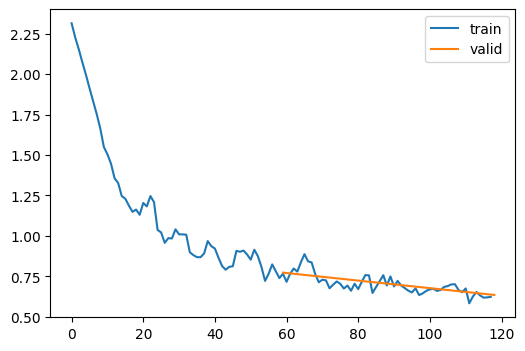

In [48]:
model = get_model()

metrics = MetricsCB(accuracy=MulticlassAccuracy(num_classes=len(ds_builder.info.features["label"].names)))
cbs = [TrainCB(), DeviceCB(), metrics, ProgressCB(plot=True)]
learn = Learner(model, dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)
     

## TrainLearner and MomentumLearner

There's another way we could make the list of 5 "exist": we could **subclass** the Learner.
Let's not use `trainCB` just to show how a subclass would work.
We define a class `TrainLearner(Learner)` as a subclass of `Learner` that implements the same 5 methods as in `trainCB`.
Now we don't need the `self.learn` anymore, because we are "in the" `Learner`, so `self.` suffices.
This way it's never going to end up going to `__getattr__` (which is only called if something doesn't exist).

In [49]:
#|export
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

To use [Huggingface Accelerate](https://huggingface.co/docs/accelerate/en/index), 
or something else that works on Huggingface data Styles, dictionary things, etc.,
we can change how it behaves, by creating a callback for training like `TrainCB`.
And if we want everything except one thing to be the same, we can inherit from `TrainCB`.

Lets define `MomentumLearner` as a subclass of `TrainLearner` which *changes* `zero_grad` to do something *"a bit crazy"*, 
instead of zeroing the gradients we multiply them by a number, e.g.,  0.85.
The previous gradients would still be there, but they would be reduced a bit.
Pytorch always adds the gradients to the existing gradients (that's why we normally call zero_grad).
But if instead we multiply the gradients by a number, a parameter, we keep the trail of gradients...
(This is like gradient accumulation callback)
<br>
We add `mom=0.85` to the constructor arguments, and call `super().__init__`.
<mark>NB: make sure to call the super classes passing in all the stuff. </mark>(We could use delegates for this.)

In [50]:
#|export
class MomentumLearner(TrainLearner):
    def __init__(self, model, dls, loss_func, lr=None, cbs=None, opt_func=optim.SGD, mom=0.85):
        self.mom = mom
        super().__init__(model, dls, loss_func, lr, cbs, opt_func)

    def zero_grad(self):
        with torch.no_grad():
            for p in self.model.parameters(): p.grad *= self.mom

Below using `MomentumLearner` but there's no `trainCB` in the `cbs` list.
It trains at the same `lr` for the same time, but `loss` improved from 0.8 to 0.55 and `accuracy` from 0.7 to 0.8.
We implemented **momentum**, which can make us reach the destination faster.
Normally for momentum we have to store a complete copy of all the gradients, 
to keep track of a running exponentially waited moving average.
But with the above "trick" we're using the `.grad` themselves to store the
exponentially weighted moving average, obtining an accelerated optimizer and memory savings.

accuracy,loss,epoch,train
0.6860,0.9662,0,train
0.8110,0.5343,0,eval
0.8227,0.4955,1,train
0.8165,0.4932,1,eval


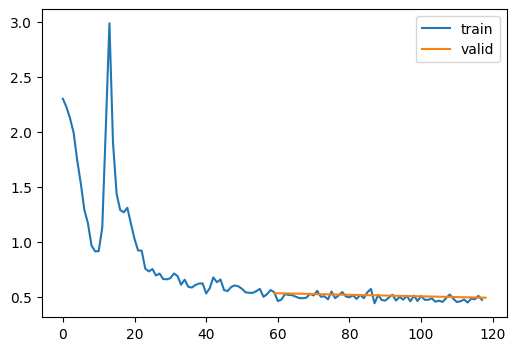

In [51]:
# NB: No TrainCB
metrics = MetricsCB(accuracy=MulticlassAccuracy(num_classes=len(ds_builder.info.features["label"].names)))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)
learn.fit(2)

## LRFinderCB

Another callback is the learning rate finder `LRFinderCB`, which increases `lr` gradually, 
by an `lr_mult` factor each batch, and plots `loss` against `lr`.
We use it to find how high can `lr` be before `loss` starts getting worse.
We want `lr` roughly where the steepest slope is.
<br>
In `before_fit` we keep track of the points in the plot: `lrs` and `losses`. 
We have to decide when to stop training, when `loss` gets worse and it has "gone off".
JH decided that `loss > self.min*3` is the criteria to stop.
We keep track of the minimum loss (`self.min`), initially set to Infinity (`math.inf`).
<br>
In `after_batch`, if it is not training (no use for `LRfinderCB` during validation), raise `CancelEpochException()`,
which stops it from doing that epoch entirely.
(`one_epoch` will handle this goes straight to the `except` which goes to the end of that code and it's going to skip it.)
<br>
We get `lr` from the dictionary `param_groups`. 
We've got to keep track of the `loss`, so append it to our list `losses`,
and if it's less than `min` we've seen, then record it as the `min`.
If it's greater than 3 times `min`, then raise the `cancelFitException` to stop everything.
Finally update `lr` to `lr_mult` times the previous value.
(In Pytorch we have to go through each `param_group`, grab the corresponding`g[lr]` and multiply it.)

In [52]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult

The `LRFinderCB()` callback needs to be instantiated first, to be able to grab its learning rates and its losses.
Notice that [plt.xscale](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.xscale.html) is used to set the x-axis scale.

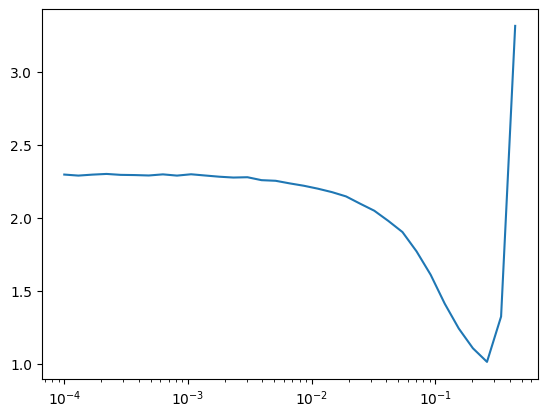

In [53]:
lrfind = LRFinderCB()
cbs = [DeviceCB(), lrfind]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=cbs)
learn.fit(1)
plt.plot(lrfind.lrs, lrfind.losses)
plt.xscale("log")

### LRFinder using Pytorch 
We can implement `LRfinderCB` with a Pytorch learning rate scheduler, `lr_scheduler`, but it will only do
one line of code for us:
<br>
`for g in self.learn.opt.param_groups: g['lr'] *= self.lr_mult`. 
Lets create a new `LRfinderCB`, using Pytorch's 
[ExponentialLR scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ExponentialLR.html#torch.optim.lr_scheduler.ExponentialLR).
<br>
NB: *JH claimed that the documentation is wrong, claims that it decays the `lr` of each parameter Group by `gamma` 
every epoch but it's not done every epoch.
Pytorch schedulers have a `step` method and the decay happens each time it calls step.*

In [54]:
#|export
from torch.optim.lr_scheduler import ExponentialLR

In `before_fit` we create `.sched = ExponentialLR(self.learn.opt, self.gamma)` that will adjust the learning rates.
It needs access to the optimizer `learn.opt` and the learning rate multiplier `gamma`.
`after_batch` rather than having a loop (as above) over the `param_groups` we just do `.shed.step()`.
<br>
Not gaining much with the Pytorch ExponentialLR scheduler, just the `self.shed.step()`.

In [55]:
#|export
class LRFinderCB(Callback):
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')

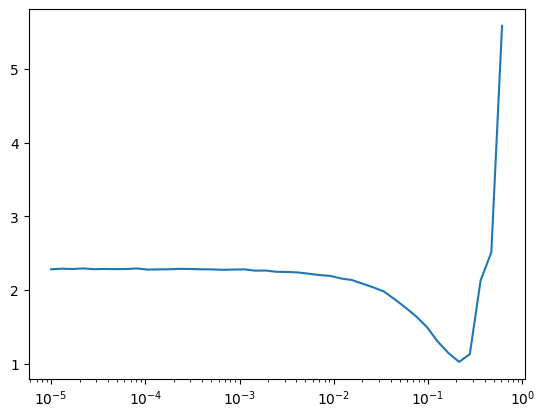

In [56]:
cbs = [DeviceCB()]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-5, cbs=cbs)
learn.fit(3, cbs=LRFinderCB())

The `@fc.patch` decorator turns a function (e.g., `lr_find`) into a method of the class after `self:` (here `Learner`).
Below defines a new method `Learner.lr_find`, which calls `self.fit` where `self` is a `Learner`,
passing in `max_epochs`, what to start the learning rate `start_lr`, and to use as `cbs` callbacks the `LRFinderCB` callback with the appropriate arguments `gamma` and `max_mult`.

In [57]:
#|export
@fc.patch
def lr_find(self:Learner, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
    self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

<span style='color:Green'> 
`@patch` is controversial in the Python community.
It is used widely and considered good on other programming languages.
JH doesn't have strong opinion, but here it was useful to add functionality to the `Learner` class.
</span>

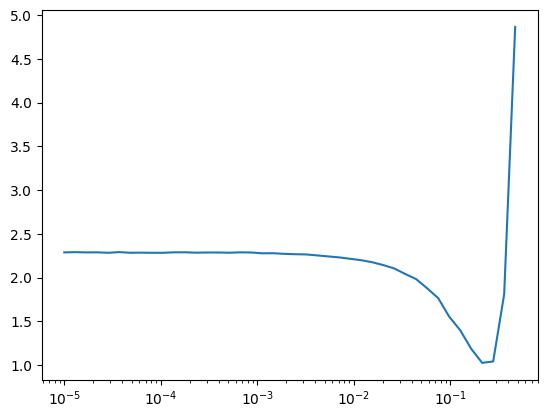

In [58]:
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=cbs).lr_find()

## Export -

In [59]:
# import nbdev; nbdev.nbdev_export()